In [375]:
! pip install torchinfo
! pip install gradio
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [373]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import gradio as gr

In [309]:
df = pd.read_excel("/content/personality_dataset.xlsx")
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,3,Yes,6,7,No,14,5,Extrovert
1,2,No,8,6,No,7,8,Extrovert
2,1,No,9,4,No,9,3,Extrovert
3,8,No,0,0,Yes,9,3,Introvert
4,5,Yes,3,0,No,2,6,Introvert


In [336]:
X = df.drop("Personality", axis=1)
y = df["Personality"]

In [339]:
# Encode target labels (e.g., introvert/extrovert)
le = LabelEncoder()
y = le.fit_transform(y)

In [340]:
# Encode non-numeric feature columns
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# Encode the target column
y = LabelEncoder().fit_transform(y)

# Now scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [341]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [342]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [343]:
# class PersonalityModel(nn.Module):
#     def __init__(self, input_size=5, hidden1=64, hidden2=32, output_size=1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, hidden1),
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Regularization
#             nn.Linear(hidden1, hidden2),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(hidden2, output_size),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.net(x)



class PersonalityModel(nn.Module):
    def __init__(self, input_size=7, hidden1=128, hidden2=64, output_size=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.net(x)



# class PersonalityModel(nn.Module):
#     def __init__(self, input_size=5, hidden1=128, hidden2=64, output_size=1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, hidden1),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden1, hidden2),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(hidden2, output_size)  # No Sigmoid here
#         )

#     def forward(self, x):
#         return self.net(x)


In [344]:
model = PersonalityModel(input_size=X.shape[1], output_size=len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [354]:
losses = []
accuracies = []

In [355]:
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


In [366]:
def compute_permutation_importance(model, X_test_tensor, y_test_tensor, metric_fn, n_repeats=5):
    model.eval()
    baseline_preds = model(X_test_tensor)
    baseline = metric_fn(baseline_preds, y_test_tensor)

    importances = np.zeros(X_test_tensor.shape[1])

    for col in range(X_test_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_test_tensor.clone()
            X_permuted[:, col] = X_permuted[torch.randperm(X_permuted.size(0)), col]
            with torch.no_grad():
                preds = model(X_permuted)
                score = metric_fn(preds, y_test_tensor)
            scores.append(score)
        importances[col] = baseline - np.mean(scores)

    return importances

In [367]:
def accuracy_metric(preds, targets):
    predicted = torch.argmax(preds, dim=1)
    return (predicted == targets).float().mean().item()

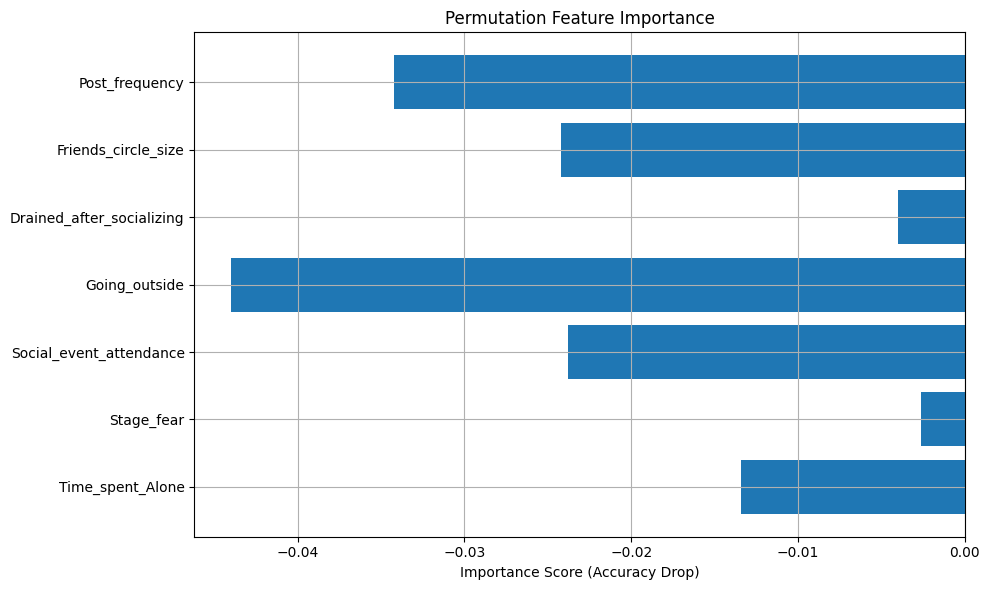

In [368]:
importances = compute_permutation_importance(model, X_test_tensor, y_test_tensor, accuracy_metric)

# Plot the results
feature_names = df.drop("Personality", axis=1).columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances)
plt.yticks(ticks=range(len(importances)), labels=feature_names)
plt.xlabel("Importance Score (Accuracy Drop)")
plt.title("Permutation Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

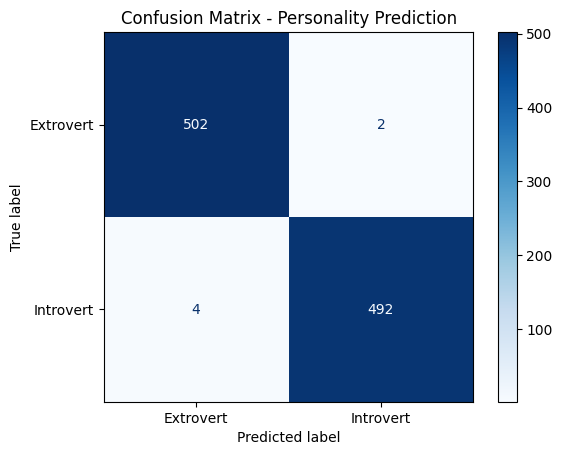

In [371]:
cm = confusion_matrix(y_test, predicted_classes.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Personality Prediction")
plt.show()

RuntimeError: Error(s) in loading state_dict for PersonalityModel:
	size mismatch for net.0.weight: copying a param with shape torch.Size([128, 7]) from checkpoint, the shape in current model is torch.Size([64, 7]).
	size mismatch for net.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net.3.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for net.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for net.6.weight: copying a param with shape torch.Size([2, 64]) from checkpoint, the shape in current model is torch.Size([3, 32]).
	size mismatch for net.6.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).